In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.pyplot import figure
from itertools import chain

%matplotlib inline

In [2]:
title_basics_imdb = pd.read_csv('./data/data.tsv', sep='\t')

/Users/maffeitheo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# drop nan values for the startYear
title_basics_imdb['startYear'] = title_basics_imdb['startYear'].replace('\\N', np.nan)
title_basics_imdb = title_basics_imdb.dropna()

In [4]:
# convert column startYear from string to float
title_basics_imdb['startYear'] = title_basics_imdb['startYear'].astype(float)

In [5]:
title_basics_imdb

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
9376974,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010.0,\N,\N,"Action,Drama,Family"
9376975,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010.0,\N,\N,"Action,Drama,Family"
9376976,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010.0,\N,\N,"Action,Drama,Family"
9376977,tt9916856,short,The Wind,The Wind,0,2015.0,\N,27,Short


In [6]:
# remove data before 1885 and after 2014 in order to have comparable data with our dataset
title_basics_imdb.drop(title_basics_imdb[title_basics_imdb['startYear'] < 1885].index, inplace = True)
title_basics_imdb.drop(title_basics_imdb[title_basics_imdb['startYear'] > 2015].index, inplace = True)

In [7]:
# extract all title types and store it in movie_metadata_only_titleType

movie_metadata_only_titleType = pd.DataFrame(title_basics_imdb, columns = ['titleType'])
movie_metadata_only_titleType['titleType'].value_counts()[:20]

tvEpisode       3805390
short            559962
movie            414844
video            195473
tvSeries         144912
tvMovie          114382
tvSpecial         26235
videoGame         23647
tvMiniSeries      21587
tvShort            8123
tvPilot               1
Name: titleType, dtype: int64

In [8]:
# keep only movie and remove all other types of titles

movie_metadata_imdb = title_basics_imdb[title_basics_imdb['titleType'].str.contains('tvEpisode') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('short') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('video') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvSeries') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvMovie') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvMiniSeries') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvSpecial') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('videoGame') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvShort') == False]
movie_metadata_imdb = movie_metadata_imdb[movie_metadata_imdb['titleType'].str.contains('tvPilot') == False]

In [9]:
# drop nan values from column genres 
movie_metadata_imdb['genres'] = movie_metadata_imdb['genres'].replace('\\N', np.nan)
movie_metadata_imdb = movie_metadata_imdb.dropna()

In [10]:
# split genres in order to use function get_count_genre
movie_metadata_imdb['genres'] = [lang.split(',') for lang in movie_metadata_imdb.genres]

In [11]:
# drop nan values from the column runtimeMinutes
movie_metadata_imdb['runtimeMinutes'] = movie_metadata_imdb['runtimeMinutes'].replace('\\N', np.nan)

In [12]:
movie_metadata_imdb

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45,[Romance]
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,\N,70,"[Action, Adventure, Biography]"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907.0,\N,90,[Drama]
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907.0,\N,NaN,[Drama]
625,tt0000630,movie,Hamlet,Amleto,0,1908.0,\N,NaN,[Drama]
...,...,...,...,...,...,...,...,...,...
9376648,tt9916162,movie,Making of 'La Virgen de los sicarios',Making of 'La Virgen de los sicarios',0,1999.0,\N,45,[Documentary]
9376869,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015.0,\N,57,[Documentary]
9376896,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007.0,\N,100,[Documentary]
9376908,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013.0,\N,NaN,[Comedy]


### Number of movies per year IMDB dataset

Text(0.5, 1.0, 'Number of movies per year IMDB dataset')

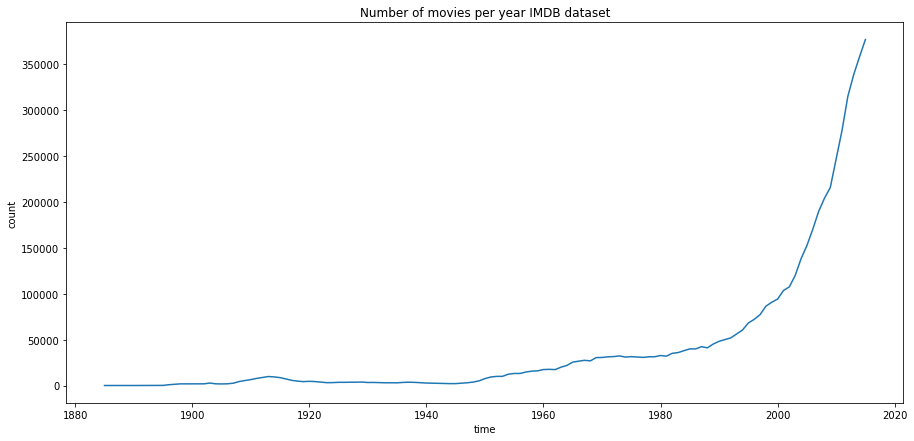

In [8]:
# plot number of movies per year IMDb dataset
fig,ax = plt.subplots(figsize =(15,7))

title_basics_imdb.groupby(by='startYear')['startYear'].count().plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('count')
ax.set_title('Number of movies per year IMDb dataset')

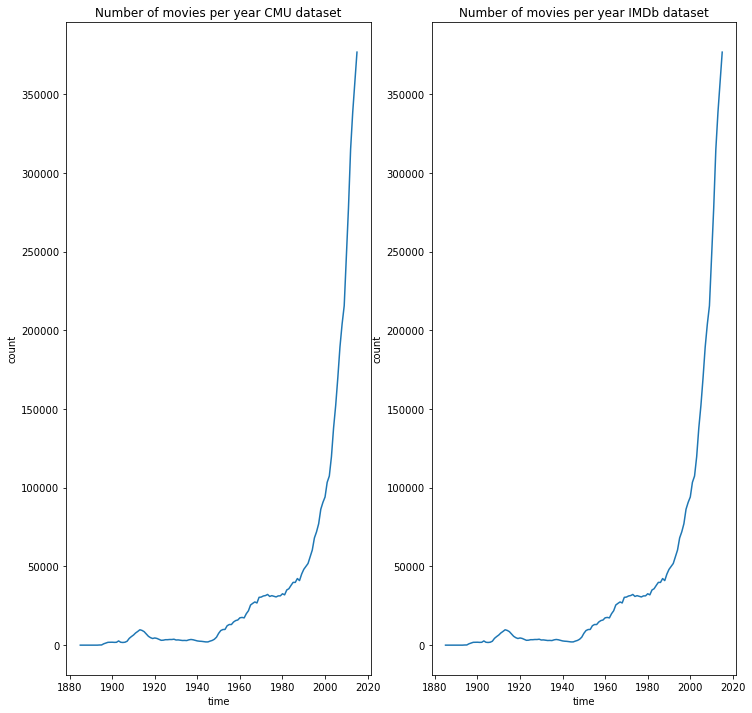

In [24]:
#fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

title_basics_imdb.groupby(by='startYear')['startYear'].count().plot(ax = ax1)
ax1.set_xlabel('time')
ax1.set_ylabel('count')
ax1.set_title('Number of movies per year CMU dataset')

title_basics_imdb.groupby(by='startYear')['startYear'].count().plot(ax = ax2)
ax2.set_xlabel('time')
ax2.set_ylabel('count')
ax2.set_title('Number of movies per year IMDb dataset')

plt.show()

In [ ]:
### 

In [13]:
# split genres in order to use function get_count_genre
movie_metadata_imdb['genres'] = [lang.split(',') for lang in movie_metadata_imdb.genres]

In [14]:
movie_metadata_imdb

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,[Romance]
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"[Action, Adventure, Biography]"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,[Drama]
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,[Drama]
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,[Drama]
...,...,...,...,...,...,...,...,...,...
9376868,tt9916620,movie,The Copeland Case,The Copeland Case,0,\N,\N,\N,[Drama]
9376869,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,[Documentary]
9376896,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,[Documentary]
9376908,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,[Comedy]


In [28]:
movie_metadata_imdb.iloc[8, 7]

'\\N'

In [25]:
movie_metadata_imdb['runtimeMinutes'] = movie_metadata_imdb['runtimeMinutes'].replace('\\N', np.nan)

In [26]:
#we use pandas wrapper
movie_metadata_imdb['runtimeMinutes'].astype(float).mean()

89.82531658354903

Text(0, 0.5, 'Number of movies')

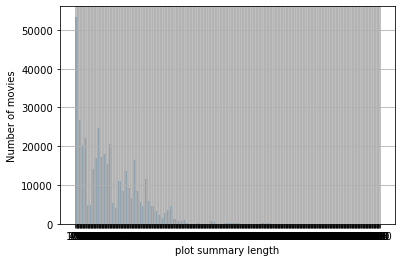

In [29]:
#we use pandas wrapper
movie_metadata_imdb['runtimeMinutes'].hist(bins = 100)

#alternatively, we can use matplotlib directly
#plt.hist(movies['worldwide_gross'].values, bins = 100)

plt.xlabel('plot summary length')
plt.ylabel('Number of movies')

In [63]:
#figure(figsize=(15, 5))

#plt.hist(movie_metadata_imdb['runtimeMinutes'], bins = 10)

#plt.xlabel('movie release year')
#plt.ylabel('number of movies')

#plt.show()

In [64]:
time = pd.DataFrame(movie_metadata_imdb, columns =['runtimeMinutes'])
time = time.dropna()
time['runtimeMinutes_int'] = time['runtimeMinutes'].apply(lambda x : int(x))
#time = time['runtimeMinutes'].astype(float)
time

,runtimeMinutes,runtimeMinutes_int
8,45,45
498,100,100
570,70,70
587,90,90
672,120,120
...,...,...
9376828,123,123
9376869,57,57
9376896,100,100
9376919,116,116


In [61]:
# remove films with runtime more than 300 
time.drop(time[time['runtimeMinutes_int'] >= 300].index, inplace = True)

In [60]:
time.describe()

,runtimeMinutes_int
count,396025.000000
mean,89.825317
std,152.610048
min,1.000000
25%,73.000000
50%,89.000000
75%,100.000000
max,54321.000000


Text(0.5, 1.0, 'Distribution of Movie Time')

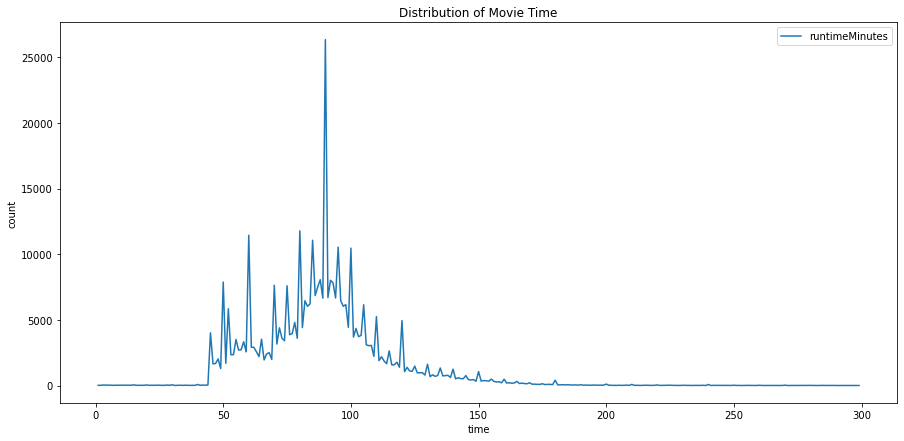

In [62]:
fig,ax = plt.subplots(figsize =(15,7))

time.groupby(by='runtimeMinutes_int').count().plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('count')
ax.set_title('Distribution of Movie Time')

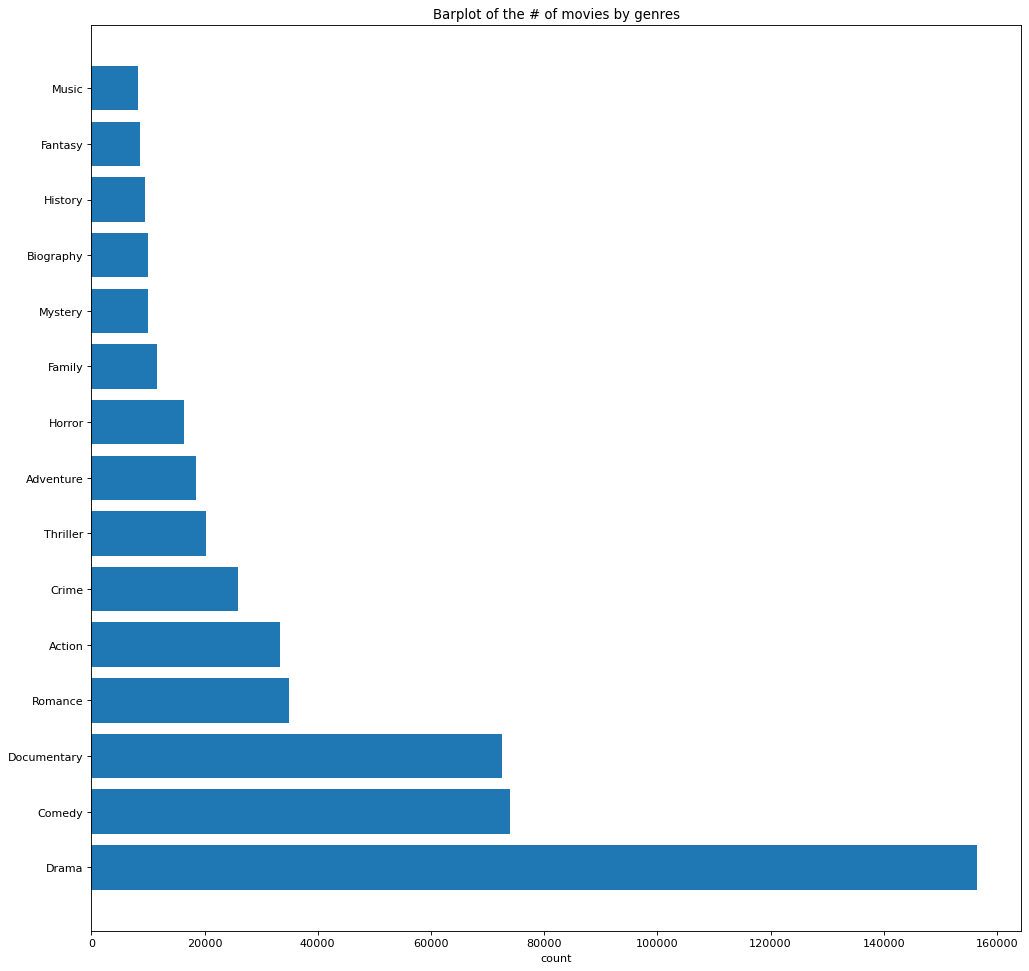

In [13]:
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

count_genre = get_count_genre(movie_metadata_imdb.genres)

#Let's only look at the top 15 genres
plt.figure(figsize=(15, 15), dpi=80)
plt.barh(count_genre.iloc[0:15].genre, count_genre.iloc[0:15]['count'])
plt.xlabel('count'); plt.title('Barplot of the # of movies by genres')
plt.show()